<a href="https://colab.research.google.com/github/hnqmz/machine_learning/blob/master/WGAN%2BGP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf 
from tensorflow.keras import layers 
import numpy as np 
import matplotlib.pyplot as plt 
from numpy.random import default_rng

np.random.seed(42)
rg=default_rng

In [2]:
IMG_SHAPE=(28, 28, 1)
BATCH_SIZE=512

noise_dim=128

fashion_mnist=tf.keras.datasets.fashion_mnist

(x_tr, y_tr), (x_te, y_te)=fashion_mnist.load_data()
print('Number of examples: %s' % (len(x_tr)))
print('Shape of examples (%s, %s)' % (x_tr.shape[1], x_tr.shape[2]))

x_tr=x_tr.reshape((-1, 28, 28, 1)).astype('float32')
x_tr=(x_tr-127.5)/127.5
#from sklearn.preprocessing import standart_scaler

4423680/4422102 [==============================] - 0s 0us/step
Number of examples: 60000
Shape of examples (28, 28)


In [3]:
def conv_block(
    x,
    filters,
    activation,
    kernel_size=(3, 3),
    strides=(1, 1),
    padding='same',
    use_bias=True,
    use_bn=False,
    use_dropout=False,
    drop_value=0.5,):

    x=layers.Conv2D(filters, kernel_size, strides=strides, padding=padding, use_bias=use_bias)(x)
    if use_bn:
        x=layers.BatchNormalization()(x)
    x=activation(x)
    if use_dropout:
        x=layers.Dropout(drop_value)(x)
    return x

In [4]:
def get_d_model():
    img_input=layers.Input(shape=IMG_SHAPE)
    x=layers.ZeroPadding2D((2, 2))(img_input)
    x=conv_block(
        x,
        64,
        kernel_size=(5, 5),
        strides=(2, 2),
        use_bn=False,
        use_bias=True,
        activation=layers.LeakyReLU(alpha=0.2),
        use_dropout=False,
        drop_value=0.3
    ) 
    x=conv_block(
        x,
        128,
        kernel_size=(5, 5),
        strides=(2, 2),
        use_bn=False,
        activation=layers.LeakyReLU(0.2),
        use_bias=True,
        use_dropout=True,
        drop_value=0.3,
    )
    x=conv_block(
        x, 
        256, 
        kernel_size=(5, 5),
        strides=(2, 2),
        use_bn=False,
        activation=tf.keras.layers.LeakyReLU(0.2),
        use_bias=True,
        use_dropout=True,
        drop_value=0.3,

    )
    x=conv_block(
        x,
        512,
        kernel_size=(5, 5),
        strides=(2, 2),
        use_bn=False,
        use_bias=True,
        activation=tf.keras.layers.LeakyReLU(0.2),
        use_dropout=False,
        drop_value=0.3,
    )

    x=layers.Flatten()(x)
    x=layers.Dropout(0.2)(x)
    x=layers.Dense(1)(x)

    d_model=tf.keras.Model(img_input, x, name='d_model')
    return d_model

d_model=get_d_model()
d_model.summary()

Model: "d_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 32, 32, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 16, 16, 64)        1664      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
dropout (Dropout)            (None, 8, 8, 128)         0   

In [5]:
def upsample_block(
    x, 
    filters, 
    activation, 
    kernel_size=(3, 3),
    strides=(1, 1),
    
    padding='same',
    use_bn=False, 
    use_bias=True,
    use_dropout=False,
    drop_value=0.3):

    x=layers.Conv2DTranspose(filters, kernel_size, strides=strides, padding=padding, use_bias=use_bias)(x)
    
    if use_bn:
        x=layers.BatchNormalization()(x)
    if activation:
        x=activation(x)
    if use_dropout:
        x=layers.Dropout(drop_value)(x)
    return x

def get_g_model():
    noise=layers.Input(shape=(noise_dim, ))
    x=layers.Dense(4*4*256, use_bias=False)(noise)
    x=layers.BatchNormalization()(x)
    x=layers.LeakyReLU(0.2)(x)

    x=layers.Reshape((4, 4, 256))(x)
    x=upsample_block(
        x, 
        128, 
        layers.LeakyReLU(0.2),
        strides=(2, 2),
        use_bias=False,
        use_bn=True, 
        use_dropout=False,
    )
    x=upsample_block(
        x, 
        64, 
        layers.LeakyReLU(0.2),
        strides=(2, 2),
        use_bias=False,
        use_bn=True,
        use_dropout=False,

    )
    x=upsample_block(
        x, 1, layers.Activation('tanh'), strides=(2, 2), use_bias=False, use_bn=True
    )
    x=layers.Cropping2D((2, 2))(x)

    g_model=tf.keras.Model(noise, x, name='g_model')
    return g_model

g_model=get_g_model()
g_model.summary()

Model: "g_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128)]             0         
_________________________________________________________________
dense_1 (Dense)              (None, 4096)              524288    
_________________________________________________________________
batch_normalization (BatchNo (None, 4096)              16384     
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 4096)              0         
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 128)         294912    
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 128)         512 

In [6]:
class WGAN(tf.keras.Model):
    def __init__(self, d_model, g_model, latent_dim, d_extra_steps=3, gp_weight=10.0):
        super().__init__()
        self.d_model=d_model
        self.g_model=g_model
        self.latent_dim=latent_dim
        self.d_steps=d_extra_steps
        self.gp_weight=gp_weight
    def compile(self, d_optimizer, g_optimizer, d_loss_fn, g_loss_fn):
        super().compile()
        self.d_optimizer=d_optimizer
        self.g_optimizer=g_optimizer
        self.d_loss_fn=d_loss_fn
        self.g_loss_fn=g_loss_fn
    def gp(self, batch_size, real_images, fake_images):
        alpha=tf.random.normal([batch_size, 1, 1, 1], 0.0, 1.0)
        diff=fake_images-real_images
        interpolated=real_images+alpha*diff 

        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            pred=self.d_model(interpolated, training=True)
        grads=gp_tape.gradient(pred, [interpolated])[0]
        norm=tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
        gpn=tf.reduce_mean((norm-1.0)**2)
        return gpn 

    def train_step(self, real_images):
        if isinstance(real_images, tuple):
            real_images=real_images[0]
        batch_size=tf.shape(real_images)[0]

        for i in range(self.d_steps):
            random_latent_vectors=tf.random.normal(
                shape=(batch_size, self.latent_dim)
            )

            with tf.GradientTape() as tape:
                fake_img=self.g_model(random_latent_vectors, training=True)
                fake_logits=self.d_model(fake_img, training=True)
                real_logits=self.d_model(real_images, training=True)

                d_cost=self.d_loss_fn(real_img=real_logits, fake_img=fake_logits)
                gp=self.gp(batch_size, real_images, fake_img)

                d_loss=d_cost+self.gp_weight*gp

            d_gradient=tape.gradient(d_loss, self.d_model.trainable_variables)
            self.d_optimizer.apply_gradients(
                zip(d_gradient, self.d_model.trainable_variables)

            )

        random_latent_vectors=tf.random.normal(shape=(batch_size, self.latent_dim))

        with tf.GradientTape() as tape:
            generated_img=self.g_model(random_latent_vectors, training=True)
            gen_img_logits=self.d_model(generated_img, training=True)
            g_loss=self.g_loss_fn(gen_img_logits)

        gen_gradient=tape.gradient(g_loss, self.g_model.trainable_variables)

        self.g_optimizer.apply_gradients(
            zip(gen_gradient, self.g_model.trainable_variables)
        )

        return {'d_loss': d_loss, 'g_loss':g_loss}

In [7]:
class GANMonitor(tf.keras.callbacks.Callback):
    def __init__(self, num_img=6, latent_dim=128):
        self.num_img=num_img
        self.latent_dim=latent_dim
    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors=tf.random.normal((self.num_img, self.latent_dim))
        generated_img=self.model.g_model(random_latent_vectors)
        generated_img=(generated_img*127.5)+127.5

        for i in range(self.num_img):
            img=generated_img[i].numpy()
            img=tf.keras.preprocessing.image.array_to_img(img)
            img.save('generated_img_{i}_{epoch}.png'.format(i=i, epoch=epoch))

In [8]:
generator_optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.0002, beta_1=0.5, beta_2=0.9
)
discriminator_optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.0002, beta_1=0.5, beta_2=0.9
)

# Define the loss functions for the discriminator,
# which should be (fake_loss - real_loss).
# We will add the gradient penalty later to this loss function.
def discriminator_loss(real_img, fake_img):
    real_loss = tf.reduce_mean(real_img)
    fake_loss = tf.reduce_mean(fake_img)
    return fake_loss - real_loss


# Define the loss functions for the generator.
def generator_loss(fake_img):
    return -tf.reduce_mean(fake_img)


# Set the number of epochs for trainining.
epochs = 20

# Instantiate the customer `GANMonitor` Keras callback.
cbk = GANMonitor(num_img=3, latent_dim=noise_dim)

# Instantiate the WGAN model.
wgan = WGAN(
    d_model=d_model,
    g_model=g_model,
    latent_dim=noise_dim,
    d_extra_steps=3,
)

# Compile the WGAN model.
wgan.compile(
    d_optimizer=discriminator_optimizer,
    g_optimizer=generator_optimizer,
    g_loss_fn=generator_loss,
    d_loss_fn=discriminator_loss,
)

# Start training the model.
wgan.fit(x_tr, batch_size=BATCH_SIZE, epochs=epochs, callbacks=[cbk])

Epoch 1/20
118/118 [==============================] - 168s 1s/step - d_loss: -12.9065 - g_loss: -9.3999
Epoch 2/20
118/118 [==============================] - 133s 1s/step - d_loss: -8.9641 - g_loss: 1.1074
Epoch 3/20
118/118 [==============================] - 133s 1s/step - d_loss: -8.2628 - g_loss: 12.7697
Epoch 4/20
118/118 [==============================] - 133s 1s/step - d_loss: -7.3365 - g_loss: 18.8487
Epoch 5/20
118/118 [==============================] - 132s 1s/step - d_loss: -6.5150 - g_loss: 26.6912
Epoch 6/20
118/118 [==============================] - 132s 1s/step - d_loss: -5.8440 - g_loss: 26.6328
Epoch 7/20
118/118 [==============================] - 132s 1s/step - d_loss: -5.3622 - g_loss: 25.9911
Epoch 8/20
118/118 [==============================] - 132s 1s/step - d_loss: -4.9319 - g_loss: 23.9385
Epoch 9/20
118/118 [==============================] - 132s 1s/step - d_loss: -4.6166 - g_loss: 21.8118
Epoch 10/20
118/118 [==============================] - 133s 1s/step - d_l

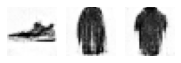

In [11]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
plt.figure(figsize=(3, 9))
for i in range(3):
  im=Image.open('generated_img_{}_19.png'.format(i))
  im=np.asarray(im)
  plt.subplot(1, 3, i+1)
  plt.imshow(im, cmap='gray_r')
  plt.axis('off')